<a href="https://colab.research.google.com/github/angelinemarym/Car-Accident-Classification/blob/main/CarAccident_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **🚓 Car Accident Classification using MobileNetV3**




## **🧮 Import Necessary Libraries**

In [ ]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random
from glob import glob

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# import cv2
import seaborn as sns

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

## **⚓ Create Helper Functions**

In [ ]:
# %pip install wget
# import wget
# wget.download('https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py')
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2023-06-23 08:36:00--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-06-23 08:36:00 (57.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## **⏳ Load and Transform Data** <br/>
Before we begin with creating and training our model, we will first set the size of the batches for our training, as well as the image height and width to set for our model

In [ ]:
BATCH_SIZE = 100
IMAGE_SIZE = (250, 250)

In [ ]:
# Mount data from Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

# Walk through each directory
dataset = "/content/gdrive/MyDrive/Machine Learning/Car Accident/"
# dataset = "./Car Accident/"
walk_through_dir(dataset)

Mounted at /content/gdrive
There are 1 directories and 1 images in '/content/gdrive/MyDrive/Machine Learning/Car Accident/'.
There are 2 directories and 0 images in '/content/gdrive/MyDrive/Machine Learning/Car Accident/data'.
There are 0 directories and 462 images in '/content/gdrive/MyDrive/Machine Learning/Car Accident/data/Accident'.
There are 0 directories and 527 images in '/content/gdrive/MyDrive/Machine Learning/Car Accident/data/Non Accident'.


## **📅 Place Data into a Dataframe** <br/>
The first column `filepaths` contains the file path location of each individual images. The second column `labels`, on the other hand, contains the class label of the corresponding image from the file path

In [ ]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [ ]:
image_df

Filepath         Label
0    /content/gdrive/MyDrive/Machine Learning/Car A...      Accident
1    /content/gdrive/MyDrive/Machine Learning/Car A...      Accident
2    /content/gdrive/MyDrive/Machine Learning/Car A...      Accident
3    /content/gdrive/MyDrive/Machine Learning/Car A...      Accident
4    /content/gdrive/MyDrive/Machine Learning/Car A...      Accident
..                                                 ...           ...
984  /content/gdrive/MyDrive/Machine Learning/Car A...  Non Accident
985  /content/gdrive/MyDrive/Machine Learning/Car A...  Non Accident
986  /content/gdrive/MyDrive/Machine Learning/Car A...  Non Accident
987  /content/gdrive/MyDrive/Machine Learning/Car A...  Non Accident
988  /content/gdrive/MyDrive/Machine Learning/Car A...  Non Accident

[989 rows x 2 columns]

## **🔭 Visualizing images from the dataset**

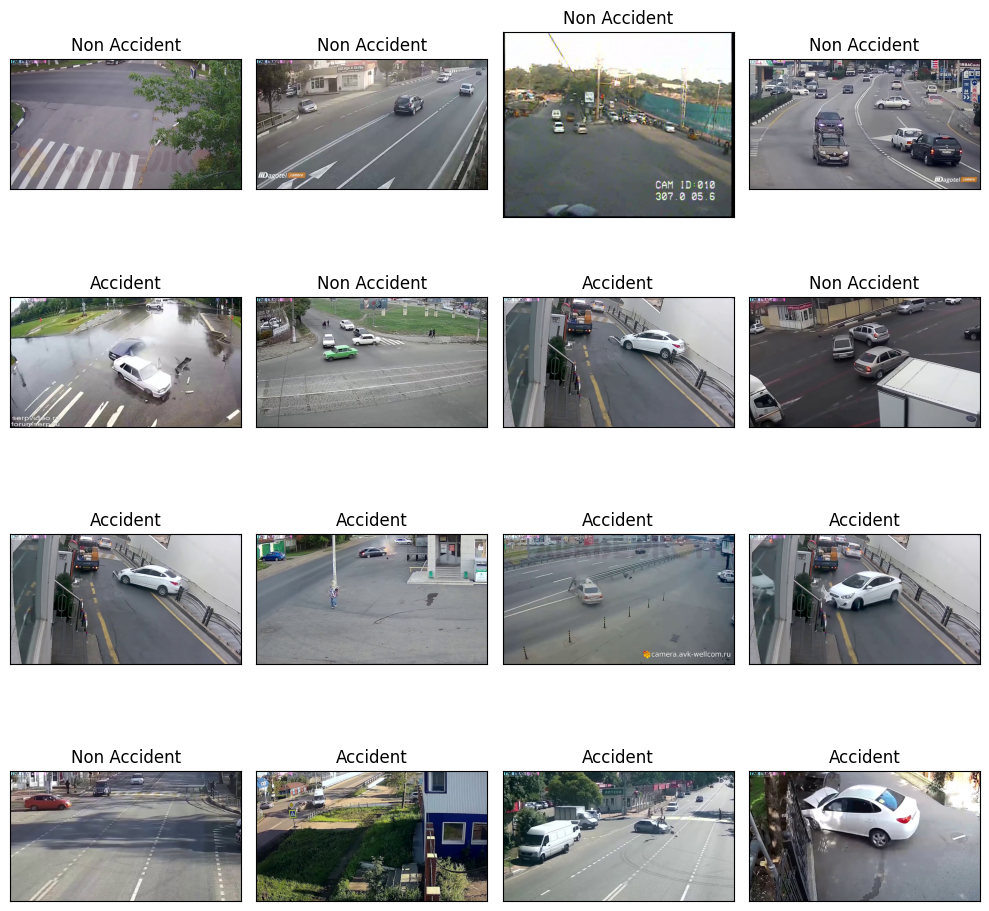

In [ ]:
# Display 9 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

## **✍ Data Preprocessing** <br/>
The data will be split into three different categories: Training, Validation and Testing. The training data will be used to train the deep learning CNN model and its parameters will be fine tuned with the validation data. Finally, the performance of the data will be evaluated using the test data(data the model has not previously seen).

In [ ]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=1)

In [ ]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input
)

In [ ]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=101,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=101,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 633 validated image filenames belonging to 2 classes.
Found 158 validated image filenames belonging to 2 classes.
Found 198 validated image filenames belonging to 2 classes.


In [ ]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(250,250),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# Setup data augmentation
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal_and_vertical"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
], name="data_augmentation")

# **🤹Training the model**
The model images will be subjected to a pre-trained CNN model called MobileNetV2. Three callbacks will be utilized to monitor the training. These are: Model Checkpoint, Early Stopping, Tensorboard callback. The summary of the model hyperparameter is shown as follows:

**Batch size** : 100

**Epochs** : 100

**Input Shape** : (250, 250, 3)

**Output layer** : 10

In [ ]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV3Large(
    input_shape=(250, 250, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

12683000/12683000 [==============================] - 0s 0us/step


In [ ]:
# Create checkpoint callback
checkpoint_path = "car_accident_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3,
                                                  restore_best_weights=True) # if val loss decreases for 3 epochs in a row, stop training

## **🚄Train the model**

In [ ]:
inputs = pretrained_model.input
x = resize_and_rescale(inputs)
x = data_augmentation(x)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)

outputs = Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs",
                                    "car_accident_classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/car_accident_classification/20230424-050232
Epoch 1/100
7/7 [==============================] - 176s 27s/step - loss: 0.8149 - accuracy: 0.4961 - val_loss: 0.7433 - val_accuracy: 0.4557
Epoch 2/100
7/7 [==============================] - 59s 8s/step - loss: 0.7779 - accuracy: 0.5656 - val_loss: 0.7288 - val_accuracy: 0.4684
Epoch 3/100
7/7 [==============================] - 59s 8s/step - loss: 0.7724 - accuracy: 0.5355 - val_loss: 0.7156 - val_accuracy: 0.4810
Epoch 4/100
7/7 [==============================] - 67s 10s/step - loss: 0.7899 - accuracy: 0.5308 - val_loss: 0.7036 - val_accuracy: 0.5380
Epoch 5/100
7/7 [==============================] - 68s 10s/step - loss: 0.7675 - accuracy: 0.5529 - val_loss: 0.6935 - val_accuracy: 0.5506
Epoch 6/100
7/7 [==============================] - 60s 8s/step - loss: 0.7702 - accuracy: 0.5498 - val_loss: 0.6823 - val_accuracy: 0.5759
Epoch 7/100
7/7 [==============================] - 67s 9s/step - loss: 

## **✔️ Model Evaluation**

In [ ]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.46550
Test Accuracy: 75.76%


## **📉Visualizing loss curves**

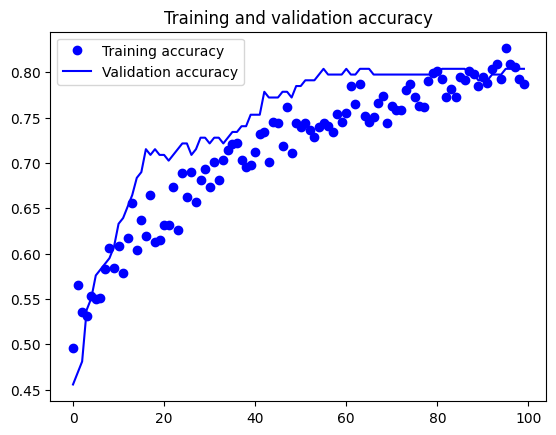

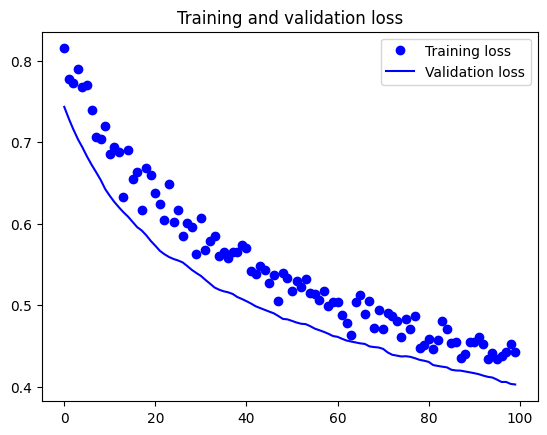

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

## **🔮Making predictions on the test data**

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

2/2 [==============================] - 16s 5s/step
The first 5 predictions: ['Accident', 'Non Accident', 'Non Accident', 'Non Accident', 'Non Accident']


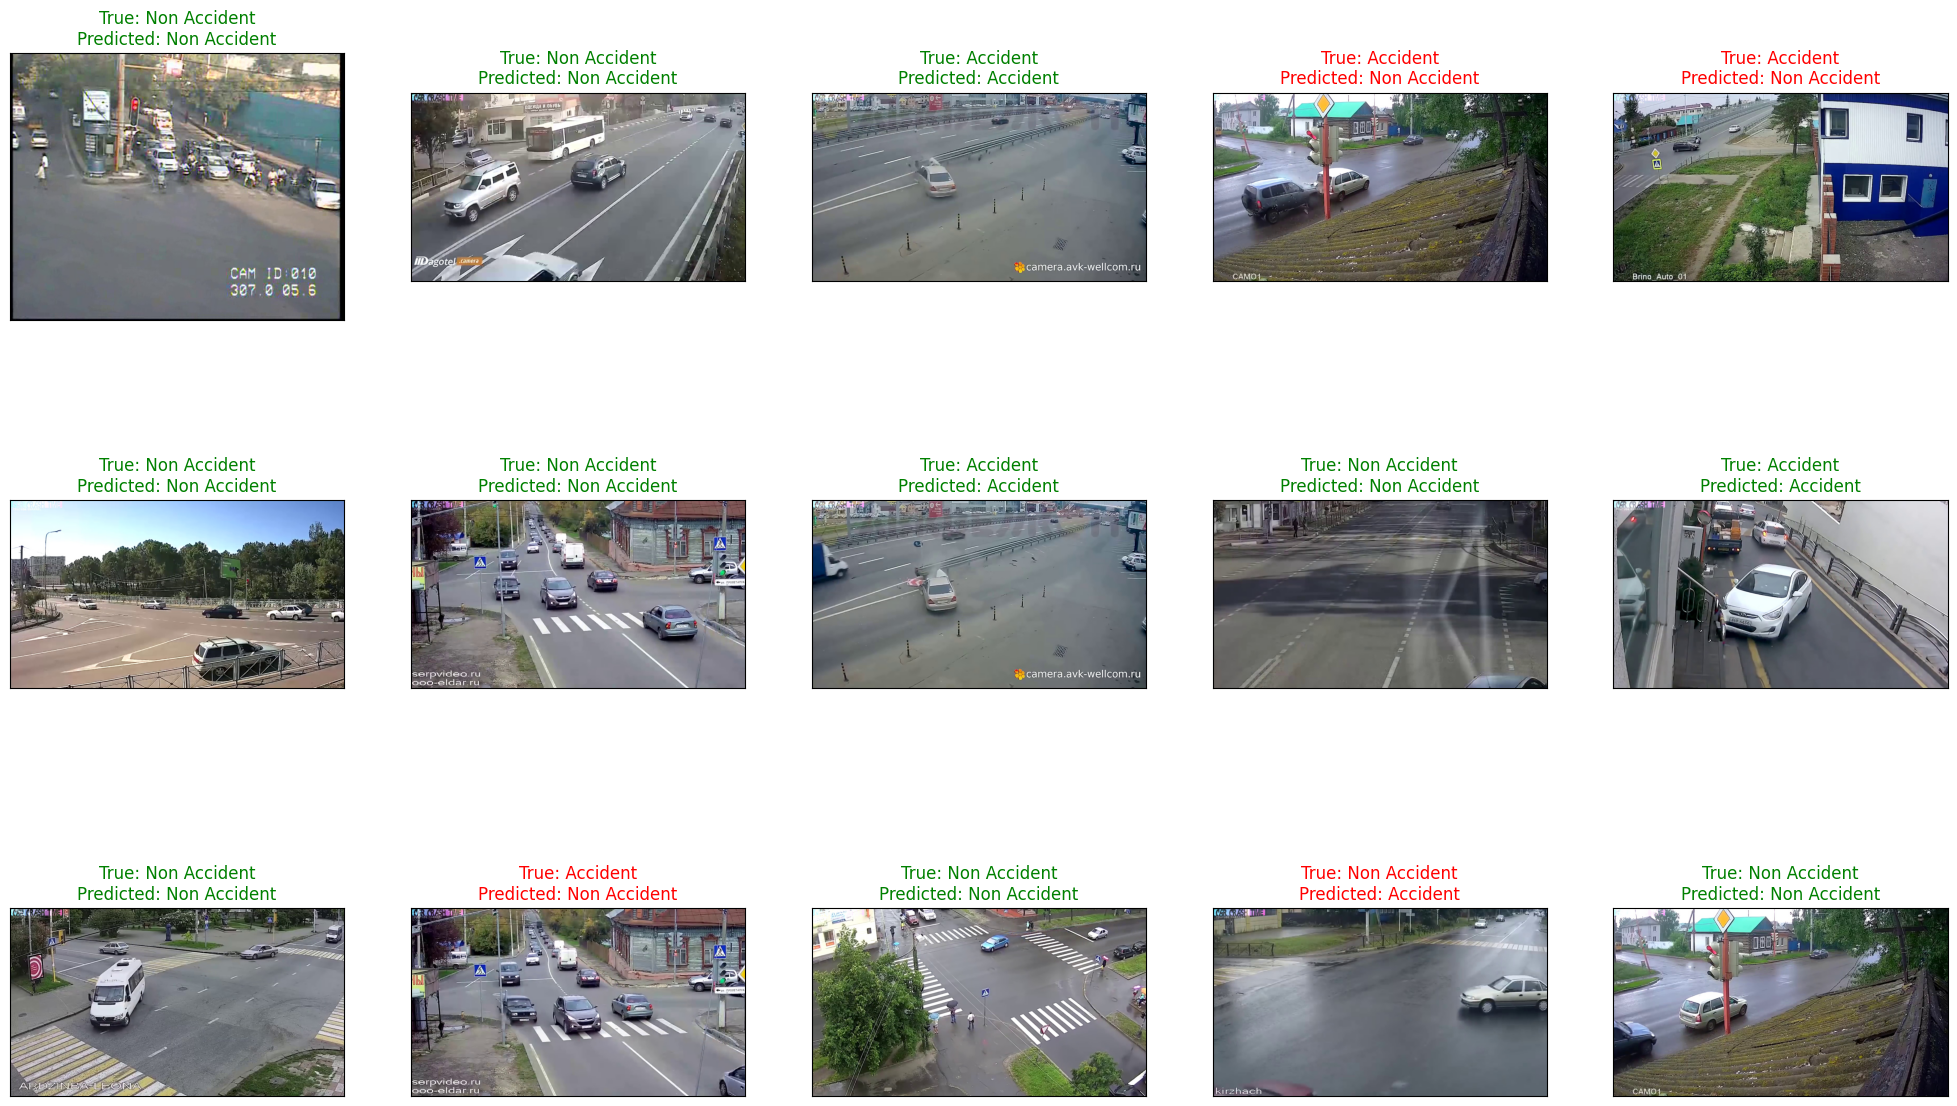

<Figure size 640x480 with 0 Axes>

In [ ]:
# Display 15 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

## **📊Plotting the classification reports**

In [ ]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

    Accident       0.73      0.73      0.73        90
Non Accident       0.78      0.78      0.78       108

    accuracy                           0.76       198
   macro avg       0.76      0.76      0.76       198
weighted avg       0.76      0.76      0.76       198



In [ ]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score     support
Accident       0.733333  0.733333  0.733333   90.000000
Non Accident   0.777778  0.777778  0.777778  108.000000
accuracy       0.757576  0.757576  0.757576    0.757576
macro avg      0.755556  0.755556  0.755556  198.000000
weighted avg   0.757576  0.757576  0.757576  198.000000

# **🚓 Car Accident Classification using EfficientNetV2**




# **🤹Training the model**
The model images will be subjected to a pre-trained CNN model called EfficientNetV2. Three callbacks will be utilized to monitor the training. These are: Model Checkpoint, Early Stopping, Tensorboard callback. The summary of the model hyperparameter is shown as follows:

**Batch size** : 100

**Epochs** : 100

**Input Shape** : (250, 250, 3)

**Output layer** : 10

In [ ]:
# Load the pretained model
pretrained_model = tf.keras.applications.efficientnet_v2.EfficientNetV2L(
    input_shape=(250, 250, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

In [ ]:
# Create checkpoint callback
checkpoint_path = "car_accident_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

## **🚄Train the model**

In [ ]:
%pip install pillow
import sys
from PIL import Image
sys.modules['Image'] = Image

Note: you may need to restart the kernel to use updated packages.


In [ ]:
inputs = pretrained_model.input
x = resize_and_rescale(inputs)
x = data_augmentation(x)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)

outputs = Dense(2, activation='softmax')(x)


model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs",
                                    "car_accident_classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/car_accident_classification/20230528-111813
Epoch 1/100
13/13 [==============================] - 325s 23s/step - loss: 1.7524 - accuracy: 0.4708 - val_loss: 0.9722 - val_accuracy: 0.4968
Epoch 2/100
13/13 [==============================] - 291s 23s/step - loss: 1.2752 - accuracy: 0.4803 - val_loss: 0.8232 - val_accuracy: 0.5285
Epoch 3/100
13/13 [==============================] - 289s 23s/step - loss: 1.1637 - accuracy: 0.5142 - val_loss: 0.8433 - val_accuracy: 0.5791
Epoch 4/100
13/13 [==============================] - 286s 22s/step - loss: 1.0973 - accuracy: 0.5024 - val_loss: 0.7478 - val_accuracy: 0.5728
Epoch 5/100
13/13 [==============================] - 286s 22s/step - loss: 1.1018 - accuracy: 0.5039 - val_loss: 0.7011 - val_accuracy: 0.6044
Epoch 6/100
13/13 [==============================] - 290s 23s/step - loss: 1.0314 - accuracy: 0.5355 - val_loss: 0.6821 - val_accuracy: 0.6392
Epoch 7/100
13/13 [==============================] 

## **✔️ Model Evaluation**

In [ ]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.36935
Test Accuracy: 83.59%


## **📉Visualizing loss curves**

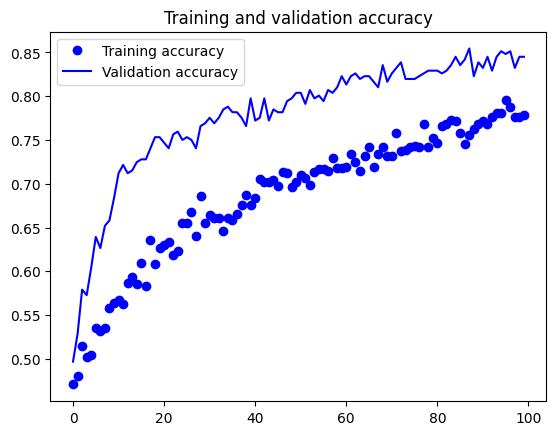

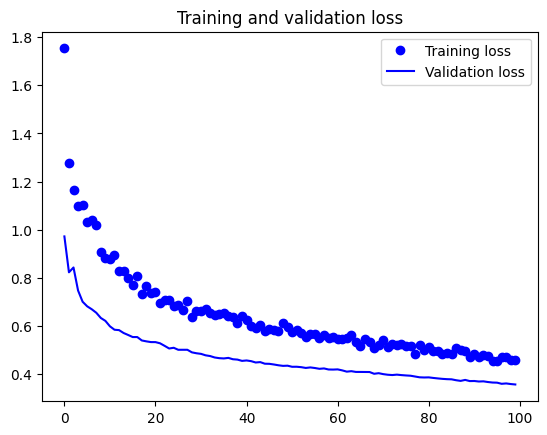

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

## **🔮Making predictions on the test data**

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

4/4 [==============================] - 76s 17s/step
The first 5 predictions: ['Accident', 'Non Accident', 'Accident', 'Accident', 'Non Accident']


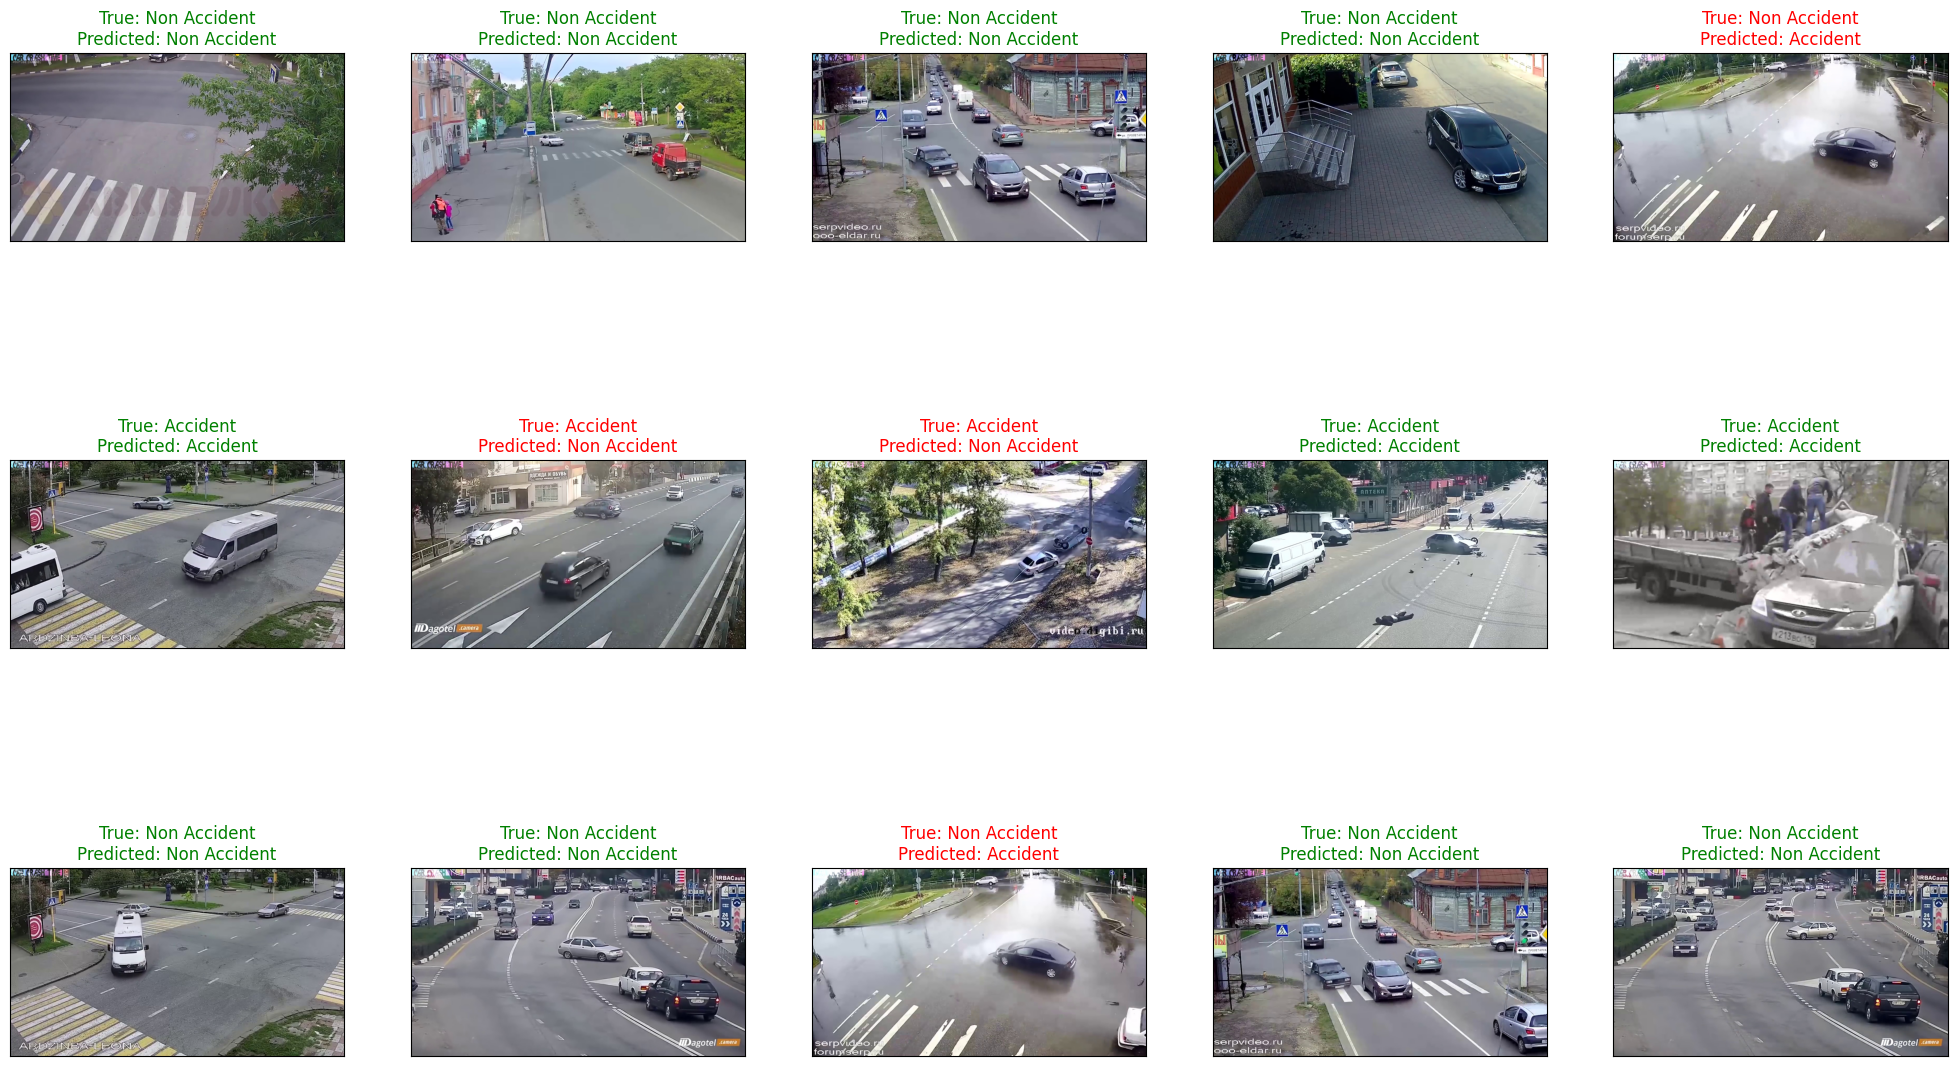

<Figure size 640x480 with 0 Axes>

In [ ]:
# Display 15 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

## **📊Plotting the classification reports**

In [ ]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

    Accident       0.86      0.77      0.81       179
Non Accident       0.82      0.89      0.86       217

    accuracy                           0.84       396
   macro avg       0.84      0.83      0.83       396
weighted avg       0.84      0.84      0.83       396



In [ ]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score     support
Accident       0.856250  0.765363  0.808260  179.000000
Non Accident   0.822034  0.894009  0.856512  217.000000
accuracy       0.835859  0.835859  0.835859    0.835859
macro avg      0.839142  0.829686  0.832386  396.000000
weighted avg   0.837500  0.835859  0.834701  396.000000

# **🚓 Car Accident Classification using ResNet50**




# **🤹Training the model**
The model images will be subjected to a pre-trained CNN model called ResNet50. Three callbacks will be utilized to monitor the training. These are: Model Checkpoint, Early Stopping, Tensorboard callback. The summary of the model hyperparameter is shown as follows:

**Batch size** : 100

**Epochs** : 100

**Input Shape** : (250, 250, 3)

**Output layer** : 10

In [ ]:
# Load the pretained model
pretrained_model = ResNet50(
    input_shape=(250, 250, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

94765736/94765736 [==============================] - 100s 1us/step


In [ ]:
# Create checkpoint callback
checkpoint_path = "car_accident_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

## **🚄Train the model**

In [ ]:
inputs = pretrained_model.input
x = resize_and_rescale(inputs)
x = data_augmentation(x)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)

outputs = Dense(2, activation='softmax')(x)


model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs",
                                    "car_accident_classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/car_accident_classification/20230531-081807
Epoch 1/100
13/13 [==============================] - 92s 7s/step - loss: 3.3546 - accuracy: 0.5190 - val_loss: 1.6277 - val_accuracy: 0.5696
Epoch 2/100
13/13 [==============================] - 85s 7s/step - loss: 2.7654 - accuracy: 0.5774 - val_loss: 1.2872 - val_accuracy: 0.6266
Epoch 3/100
13/13 [==============================] - 83s 6s/step - loss: 2.7606 - accuracy: 0.5498 - val_loss: 1.1465 - val_accuracy: 0.6234
Epoch 4/100
13/13 [==============================] - 84s 7s/step - loss: 2.4928 - accuracy: 0.6011 - val_loss: 1.0165 - val_accuracy: 0.6646
Epoch 5/100
13/13 [==============================] - 83s 6s/step - loss: 2.3553 - accuracy: 0.6090 - val_loss: 0.9165 - val_accuracy: 0.6962
Epoch 6/100
13/13 [==============================] - 83s 6s/step - loss: 2.2005 - accuracy: 0.6003 - val_loss: 0.8266 - val_accuracy: 0.6930
Epoch 7/100
13/13 [==============================] - 83s 6s/ste

## **✔️ Model Evaluation**

In [ ]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.16469
Test Accuracy: 95.20%


## **📉Visualizing loss curves**

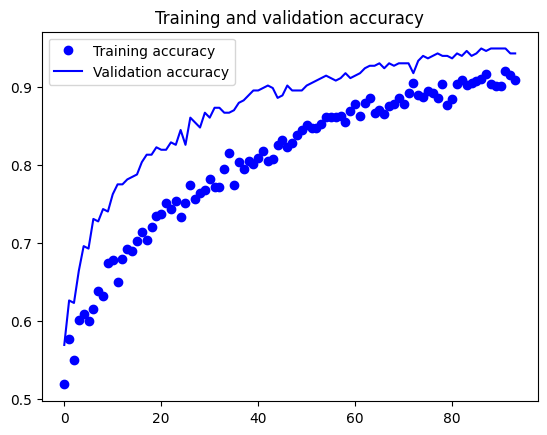

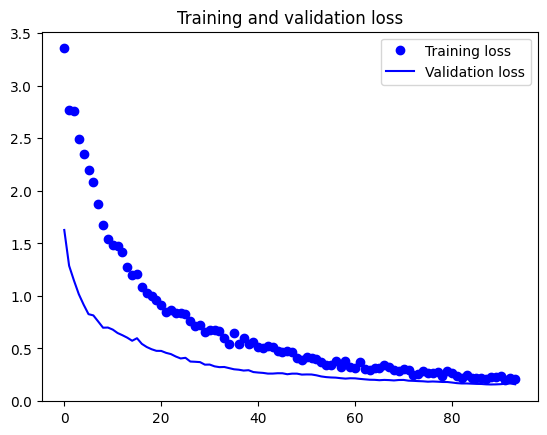

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

## **🔮Making predictions on the test data**

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

4/4 [==============================] - 23s 5s/step
The first 5 predictions: ['Accident', 'Non Accident', 'Non Accident', 'Accident', 'Accident']


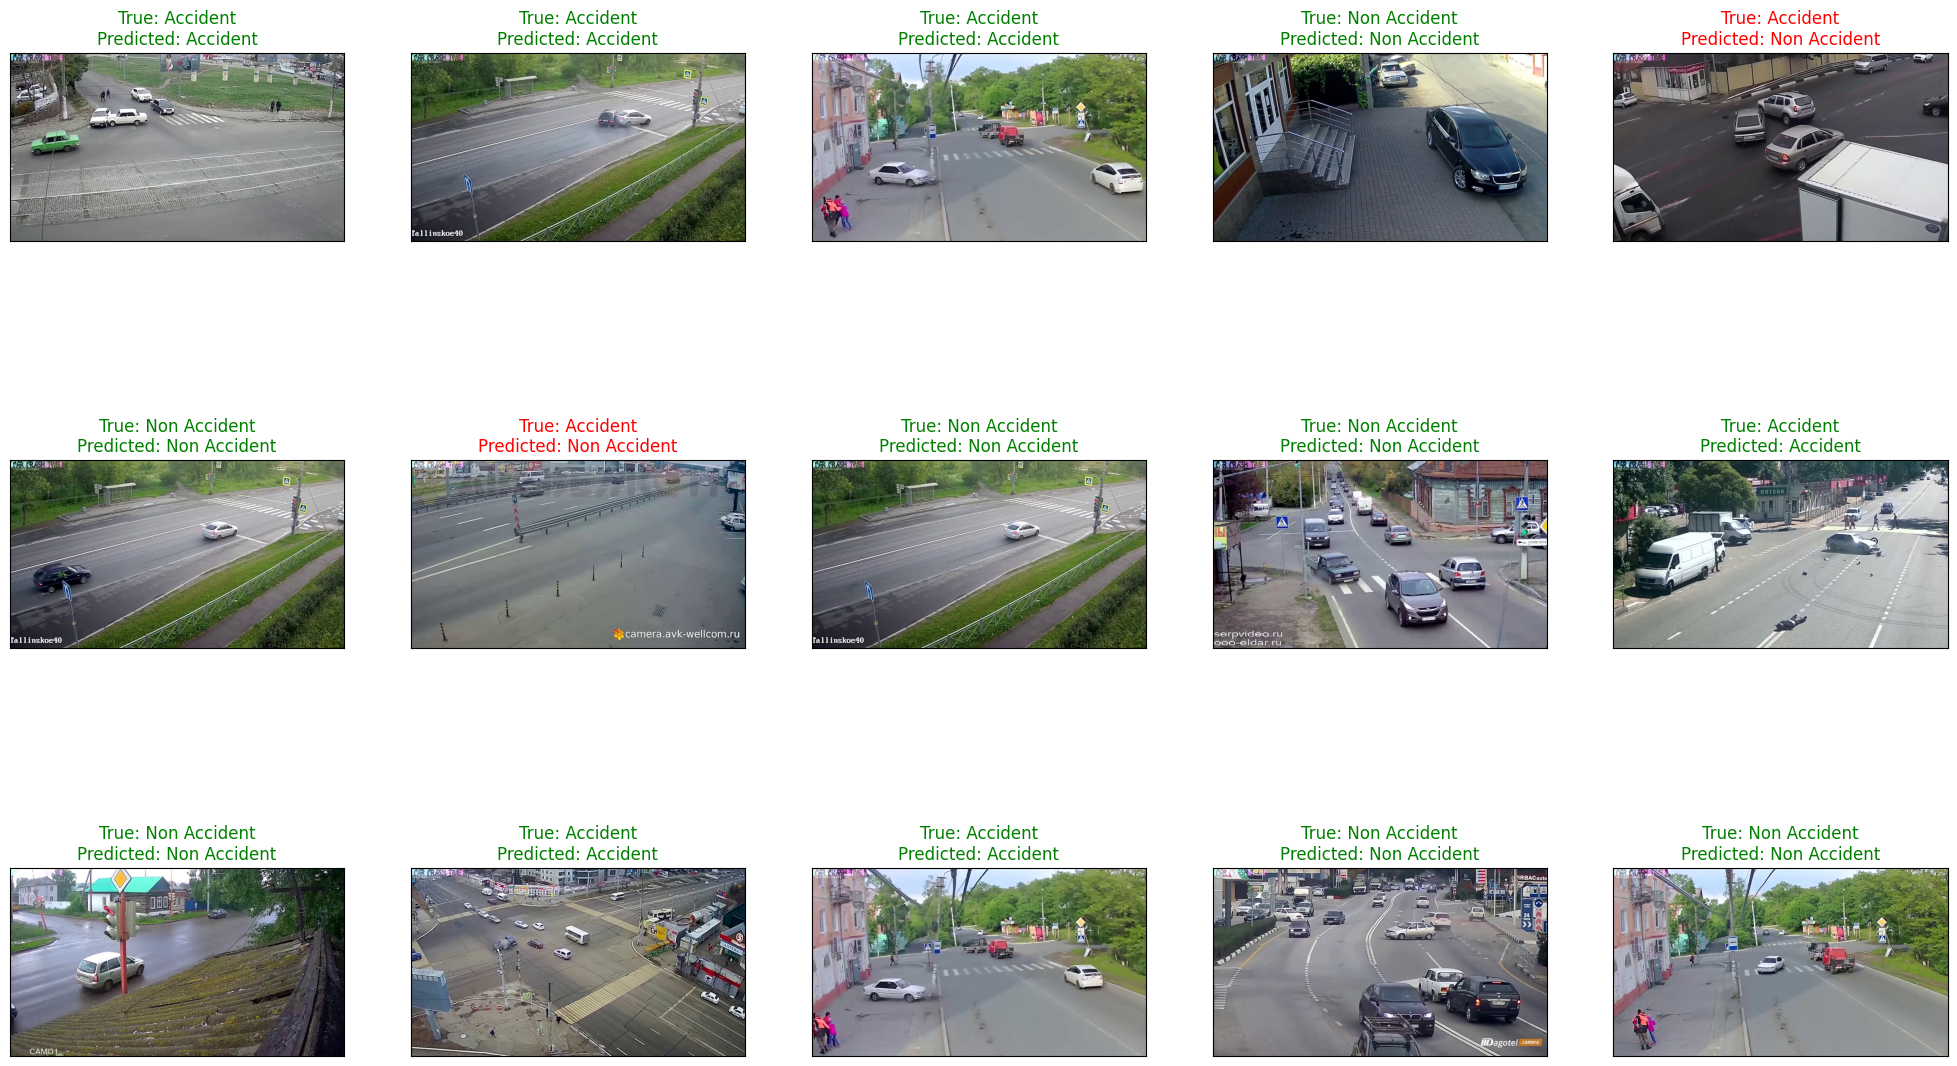

<Figure size 640x480 with 0 Axes>

In [ ]:
# Display 15 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

## **📊Plotting the classification reports**

In [ ]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

    Accident       0.97      0.92      0.95       179
Non Accident       0.94      0.98      0.96       217

    accuracy                           0.95       396
   macro avg       0.95      0.95      0.95       396
weighted avg       0.95      0.95      0.95       396



In [ ]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score    support
Accident       0.970588  0.921788  0.945559  179.00000
Non Accident   0.938053  0.976959  0.957111  217.00000
accuracy       0.952020  0.952020  0.952020    0.95202
macro avg      0.954321  0.949373  0.951335  396.00000
weighted avg   0.952760  0.952020  0.951889  396.00000